# Introduction

GAN had been interested me when I first saw it back in two years from now. This notebook is similar to the one created in [this course](https://www.coursera.org/learn/generative-deep-learning-with-tensorflow). My main objective is to explain the concept in more detail. While the concept sounds nice, the coding part be confusing. I'll do my best to correlate the coding part with the mathematics and the theory. That being said, I won't touch on the different types of the Generative Networks. My concern is not building the best GAN architecture for the given problem. If your are serios about building GAN, check out "Generative" category under "Advanced" section in Tensorflow website.

We will use Fashion Mnist dataset for this project. I hope you'll find it helpful.


In [1]:
#importing the libraries
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

#SEED THE PROCESS
SEED = 42
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
#import the dataset
(dataset,_),(_,_) = tf.keras.datasets.mnist.load_data()

#prepare the dataset
BATCH_SIZE = 32
dataset = (dataset /255.).astype('float32')
dataset = tf.data.Dataset.from_tensor_slices(dataset).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

11490434/11490434 [==============================] - 2s 0us/step


#Discriminator

Discriminator is our first stop because it is relatively easy to understand. It gets the real images from outside and the fake images by generator then decides which one is fake and which one is not. Therefore, *independent from the dataset, the objective of discriminator is doing a binary classification*.

Let's recall the loss function we use for binary classification (binary cross entropy):

\

$min-\frac 1 n∑\{y*log(h(Θ)) + (1-y)*log(1-h(Θ))\}$

\

where $h(Θ)$ is the hypothesis function.

What is our hypothesis function? The output of discriminator. For the first component, $h(Θ)$ is $D(x)$ or output of the discriminator for the real images and for the second component, $h(Θ)$ is $D(G(z))$ or output of the discriminator for the fake images. If you didn't understand, bear with me I'll explain how.

z is a subset which is sampled from Standard Normal Distribution:

\

$z \sim N(0,1)$

\

This noise is used for generating fake images by the generator. We denote the fake images by $G(z)$. Therefore the prediction of discriminator to the fake images would be $D(G(z))$.

If we use this fact, we get the a similar equation:

Discriminator gradient update equation:

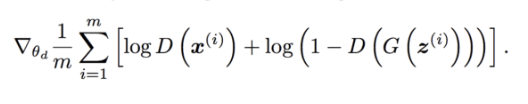

Generator gradient update equation:

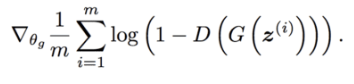


The references for the images: [link](https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/)

In [4]:
#define discriminator
discriminator = tf.keras.Sequential([
    layers.Flatten(),
    layers.Dense(128,activation = 'selu'),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(1,activation = 'sigmoid')
])

#compile the discriminator
discriminator.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam'
)

# Generator

The generator is a bit harder to understand. We have to think in reverse. Here is my explanation which potentially save your time (at least I spent lots of time to correlate the code with math):

*If we freeze the discriminator, then give the fake images and labels of 1:*

* If discriminator also labels this as 1 then the cross entropy loss is minimized for the particular instance i.e. *the generator understands that it fooled the discriminator.*

* If discriminator labels the fake image as 0 then the cross entropy loss is maximized i.e. *the generator gets a feedback telling it has to update its strategy to generate fake images.*


In [5]:
#define generator
generator = tf.keras.Sequential([
    layers.Dense(64,activation = 'selu'),
    layers.Dense(128,activation = 'selu'),
    layers.Dense(28*28,activation = 'sigmoid'),
    layers.Reshape([28,28])
])

# Building GAN

If one understands the things I mentioned above, the rest of the work becomes trivial. We sequentially train the discriminator and generator until generator becomes really good at its job!.

In [6]:
#freeze the discriminator
discriminator.trainable = False

#create the GAN model
gan = tf.keras.Sequential([generator,discriminator])
gan.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam'
)

In [7]:
#define parameters for the training loop
EPOCHS = 20
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')

  #initialize a container to store  the losses
  discriminator_losses = []
  generator_losses = []

  for train_batch in tqdm(dataset):

    #in case a batch contains less than 32 images we should
    #determine the size of batch during the process
    BATCH_SIZE = train_batch.shape[0]

    #create the noise and the fake image
    noise = tf.random.normal(shape = [BATCH_SIZE,32])
    fake_image = generator(noise)

    #concatenate the fake and real images
    #(we will give it to the discriminator later)
    concatenated_images = tf.concat([fake_image,train_batch], axis = 0)
    concatenated_labels = tf.constant([0.] * BATCH_SIZE + [1.]*BATCH_SIZE)

    #train the discriminator only on the batch
    #for the further info: https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_on_batch:~:text=Scalar%20training%20loss%20(if%20the%20model%20has%20a%20single%20output%20and%20no%20metrics)%20or%20list%20of%20scalars%20(if%20the%20model%20has%20multiple%20outputs%20and/or%20metrics).%20The%20attribute%20model.metrics_names%20will%20give%20you%20the%20display%20labels%20for%20the%20scalar%20outputs.
    discriminator_loss = discriminator.train_on_batch(x = concatenated_images, y = concatenated_labels)
    discriminator_losses.append(discriminator_loss)

    #now it's time to train generator
    #freeze the discriminator
    discriminator.trainable = False

    #create noise and fake data
    noise = tf.random.normal(shape = [BATCH_SIZE,32])

    #create the generator labels
    generator_labels = tf.constant([1.] * BATCH_SIZE)

    #train the GAN (only generator but in the guidence of discriminator)
    generator_loss = gan.train_on_batch(x = noise, y = generator_labels)
    generator_losses.append(generator_loss)

  #compute the average losses at the end of each epoch
  average_discriminator_loss = np.mean(discriminator_losses)
  average_generator_loss = np.mean(generator_losses)

  #display the loss
  print("Discriminor Loss:", np.round(average_discriminator_loss,4))
  print("Generator Loss:", np.round(average_generator_loss,4))






Epoch 1/20


100%|██████████| 1875/1875 [00:57<00:00, 32.49it/s]


Discriminor Loss: 0.0259
Generator Loss: 8.3928
Epoch 2/20


100%|██████████| 1875/1875 [00:41<00:00, 45.33it/s]


Discriminor Loss: 0.0618
Generator Loss: 7.2437
Epoch 3/20


100%|██████████| 1875/1875 [00:43<00:00, 42.95it/s]


Discriminor Loss: 0.1833
Generator Loss: 4.046
Epoch 4/20


100%|██████████| 1875/1875 [00:41<00:00, 44.72it/s]


Discriminor Loss: 0.2666
Generator Loss: 2.9302
Epoch 5/20


100%|██████████| 1875/1875 [00:43<00:00, 43.03it/s]


Discriminor Loss: 0.2629
Generator Loss: 2.9311
Epoch 6/20


100%|██████████| 1875/1875 [00:41<00:00, 45.20it/s]


Discriminor Loss: 0.2615
Generator Loss: 2.8097
Epoch 7/20


100%|██████████| 1875/1875 [00:43<00:00, 43.53it/s]


Discriminor Loss: 0.2694
Generator Loss: 2.7839
Epoch 8/20


100%|██████████| 1875/1875 [00:41<00:00, 45.21it/s]


Discriminor Loss: 0.2925
Generator Loss: 2.5958
Epoch 9/20


100%|██████████| 1875/1875 [00:41<00:00, 44.69it/s]


Discriminor Loss: 0.3071
Generator Loss: 2.4689
Epoch 10/20


100%|██████████| 1875/1875 [00:42<00:00, 44.25it/s]


Discriminor Loss: 0.3124
Generator Loss: 2.444
Epoch 11/20


100%|██████████| 1875/1875 [00:42<00:00, 44.41it/s]


Discriminor Loss: 0.3151
Generator Loss: 2.449
Epoch 12/20


100%|██████████| 1875/1875 [00:41<00:00, 45.13it/s]


Discriminor Loss: 0.3084
Generator Loss: 2.4788
Epoch 13/20


100%|██████████| 1875/1875 [00:41<00:00, 45.55it/s]


Discriminor Loss: 0.3126
Generator Loss: 2.4537
Epoch 14/20


100%|██████████| 1875/1875 [00:42<00:00, 43.86it/s]


Discriminor Loss: 0.3096
Generator Loss: 2.499
Epoch 15/20


100%|██████████| 1875/1875 [00:41<00:00, 44.92it/s]


Discriminor Loss: 0.3099
Generator Loss: 2.4801
Epoch 16/20


100%|██████████| 1875/1875 [00:42<00:00, 44.43it/s]


Discriminor Loss: 0.3072
Generator Loss: 2.4569
Epoch 17/20


100%|██████████| 1875/1875 [00:41<00:00, 45.73it/s]


Discriminor Loss: 0.3147
Generator Loss: 2.3821
Epoch 18/20


100%|██████████| 1875/1875 [00:42<00:00, 43.83it/s]


Discriminor Loss: 0.3159
Generator Loss: 2.3584
Epoch 19/20


100%|██████████| 1875/1875 [00:42<00:00, 44.27it/s]


Discriminor Loss: 0.3259
Generator Loss: 2.3443
Epoch 20/20


100%|██████████| 1875/1875 [00:43<00:00, 43.37it/s]

Discriminor Loss: 0.3263
Generator Loss: 2.3045


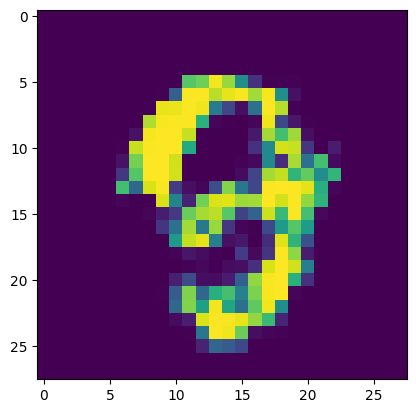

In [8]:
#visualize a random image from generator
random_idx = np.random.randint(0,len(fake_image))
plt.imshow(fake_image[random_idx])